# Analysis of a Birth-Death Processes via Moment Bounding Schemes

In this example we wish to study the statistics of the simple nonlinear birth-death process
        
        ∅ → A
        2A → A
        
following mass-action kinetics. To define the underlying jump process it is convenient to utilize Catalyst.jl's functionality and simply define a reaction network with the above reactions.

In [2]:
using MarkovBounds, MosekTools, Plots, Catalyst

┌ Warning: backend `GR` is not installed.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/backends.jl:43


We will need to make reference to the species A in the network at several occasions. We therefore extract the symbolic variable using Catalyst.jl's species function.

In [3]:
birth_death = @reaction_network begin
    1.0, ∅ --> A
    0.01, 2A --> A
end

Model ##ReactionSystem#229
States (1):
  A(t)
Parameters (0):

Throughout, we will further assume that the initial state of the process is known with deterministic certainty. The initial condition is supplied in form of a dictionary mapping the symbolic variable of all species in the process to their initial value. In this case, we assume that the initial count of species A is 2.

In [4]:
A = species(birth_death)[1] # extract symbolic variable referencing species A
A0 = Dict(A => 2.0); # define initial condition of the reactio network

On a technical note, it shall also be emphasized that in biochemical applications it is very important to provide scales for the molecular counts of the different species in the system. Otherwise numerical instabilities will likely cause inaccurate solutions. The scales are provided in the same format as the initial conditions. The scales need not be accurate and can be obtained in many sensible ways, for example by looking at a single trajectory of the network or even at the deterministic rate-law model. For closed systems, MarkovBoundsSOS allows to compute scales based on the stoichiometry in the system.

In [5]:
A_scale = Dict(A => 10.0); # define the "expected" scale of the molecular count of A at steady state.

With these pieces of input data, we can start analyzing the statistics of the stochastic reaction network/jump process.
For example, we can find upper and lower bounds on the mean count of species A with respect to the stationary distribution of the process. This can be done by calling the function `stationary_mean` specifying the reaction network, the species of which bounds are sought, an order for the relaxation used for computing the bounds, an appropriate solver and (if desired) scales for the different species as inputs. In our case the reaction network is the birth-death network defined above and we care species A. The order of the relaxation used is left to the user to decide on a trade-off between computational cost and bound quality; the larger the order is chosen, the better the bounds become (in absence of numerical issues). It is generally advisable to start with low orders (2-6) and only go beyond these values if necessary as numerical instabilities become more pronounced issues at high orders. While any SDP solver supported by JuMP (https://jump.dev/JuMP.jl/stable/installation/#Supported-solvers) can be used, we recommend with sticking with the interior-point based solvers such as Mosek, SeDuMi, SDPA, or SDPT3. With all these pieces in place, the bounds can be computed by a simple function call:

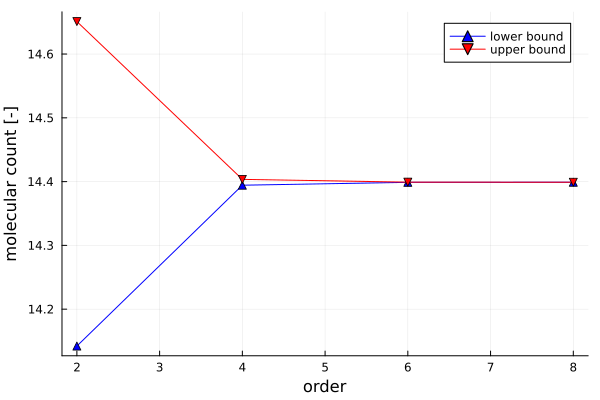

In [6]:
mean_bounds = []
orders = [2, 4, 6, 8]
solver = optimizer_with_attributes(Mosek.Optimizer, "LOG" => 0)
for order in orders
    b = stationary_mean(birth_death, A, order, solver, A_scale);
    push!(mean_bounds, b)
end
p = plot(orders, [b[1].value for b in mean_bounds], marker = :^, color=:blue, label="lower bound",
         xlabel="order", ylabel="molecular count [-]")
plot!(p, orders, [b[2].value for b in mean_bounds], marker = :v, color=:red, label="upper bound")
display(p)

Similarly, we can compute an upper bound on the variance of the stationary distribution of the process.

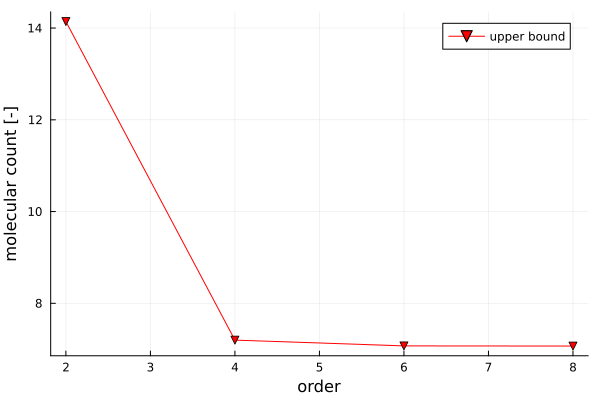

In [7]:
var_ub = []
orders = [2, 4, 6, 8]
for order in orders
    b = stationary_variance(birth_death, A, order, solver, A_scale)
    push!(var_ub, b)
end
p = plot(orders, [var.value for var in var_ub], color=:red, label="upper bound", marker = :v,
         xlabel="order", ylabel="molecular count [-]")
display(p)

While a lower bound of the variance can not be computed directly, we can use the fact that we can compute bounds on the expecation of any polynomial of the system state with respect to the stationary distribution. Accordingly, we can simply compute a lower bound on 𝔼[A²] and combine this with the previously computed upper bound on 𝔼[A] to find a valid lower bound on the variance Var[A] = 𝔼[A²] - 𝔼[A]². To that end, we first transform the reaction network into a ReactionProcess using the function `reaction_process_setup`. This ReactionProcess features a jump process that is equivalent to the reaction network, however, accounts for potential reaction invariants and applies scales to the state. Moreover, the ReactionProcess provides a map between the molecular species of the network on the states of the jump process for easy interpretation of the results.

In [8]:
reaction_process, x0 = reaction_process_setup(birth_death, A0, scales = A_scale);

Now we can compute a lower bound on Var(A)

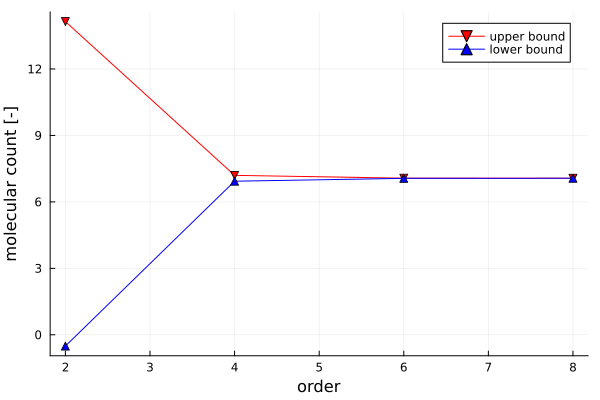

In [9]:
var_lb = []
for order in orders
    b = stationary_polynomial(reaction_process.JumpProcess, reaction_process.species_to_state[A]^2, order, solver)
    push!(var_lb, b)
end
plot!(p, orders, [var.value for var in var_lb] - [b[2].value^2 for b in mean_bounds], color=:blue, marker = :^, label="lower bound")
display(p)

Everything presented above generalizes to the problem of bounding the expectation of moments and related statistics along at any finite time. For example, we can find lower and upper bounds on the mean molecular count of species A after 10 seconds:

        transient_mean(birth_death, A0, A, 4, [10.0], Mosek.Optimizer, A_scale)

These transient bounds can not only be improved by increasing the order of the relaxation but also by refining discretization of the temporal domain. This discretization is specified by providing an ordered list of time points in place of simply the time at which the bounds are to be evaluated. The last time point in this list refers to the time at which the bounds are evaluated.

This way, we can for example evaluate bounds on the trajectories of the mean and the variance of the molecular count of species A by computing bounds at different time points:

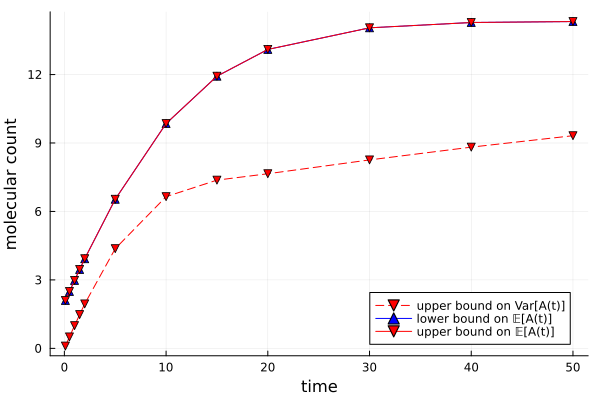

In [10]:
var_ub = []
mean_bounds = []
nT = 10 # number of intervals used to discretize the time domain
Ts = [0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0]
for T in Ts
    trange = range(0, T, length=nT+1)
    b = transient_mean(birth_death, A0, A, 4, trange, solver, A_scale)
    push!(mean_bounds, b)
    b = transient_variance(birth_death, A0, A, 4, trange, solver, A_scale)
    push!(var_ub, b)
end
p = plot(Ts, [var.value for var in var_ub], color=:red, marker = :v, linestyle=:dash, label="upper bound on Var[A(t)]",
         xlabel="time",
         ylabel="molecular count", legend = :bottomright)
plot!(p, Ts, [b[1].value for b in mean_bounds], color=:blue, marker = :^, label="lower bound on 𝔼[A(t)]")
plot!(p, Ts, [b[1].value for b in mean_bounds], color=:red, marker = :v, label="upper bound on 𝔼[A(t)]")
